In [1]:
from __future__ import print_function
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import time


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, stride=1)
        self.conv2 = nn.Conv2d(32, 64, 3,stride=1)
        self.fc1 = nn.Linear(5*5*64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.drop = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(2, 2)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool2d(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool2d(x)
        x = self.drop(x)
        x = x.view(-1, 5*5*64)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.log_softmax(x)

class DeeperNet(nn.Module):
    def __init__(self):
        super(DeeperNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1,padding=1)
        self.bn_1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3,stride=1,padding=1)
        self.bn_2 = nn.BatchNorm2d(32)
        
        self.conv1_2 = nn.Conv2d(32, 64, 3, stride=1,padding=1)
        self.bn_1_2 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, 3,stride=1,padding=1)
        self.bn_2_2 = nn.BatchNorm2d(64)
                
        
        self.fc1 = nn.Linear(7*7*64, 250)
        self.fc2 = nn.Linear(250, 10)
        self.small_drop = nn.Dropout(p=0.2)
        self.big_drop  = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(2, 2)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.bn_1(x)
        x = self.relu(self.conv2(x))
        x = self.bn_2(x)
        x = self.max_pool2d(x)
        x = self.small_drop(x)
        
        x = self.relu(self.conv1_2(x))
        x = self.bn_1_2(x)
        x = self.relu(self.conv2_2(x))
        x = self.bn_2_2(x)
        x = self.max_pool2d(x)
        x = self.small_drop(x)
        
        x = x.view(-1, 7*7*64)
        x = self.relu(self.fc1(x))
        x = self.big_drop(x)
        x = self.fc2(x)
        return self.log_softmax(x)

In [15]:
def train(log_interval, model, device, train_loader, optimizer, epoch, if_all):
    model.train()
    if if_all:
        train_size = len(train_loader.dataset)
    else:
        train_size = int(np.float((len(train_loader.dataset) * (1-validation_size))))
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss_f = nn.NLLLoss()
        loss = loss_f(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), train_size,
                100. * batch_idx / len(train_loader), loss.item()))

def validate(model, device, val_loader):
    model.eval()
    predictions = np.array([])
    targets = np.array([])
    val_size = int(np.float((len(val_loader.dataset) * validation_size)))
    
    test_loss = 0
    correct = 0
    loss_f = nn.NLLLoss(reduction='sum')

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_f(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            predictions = np.append(predictions, pred.cpu().numpy().ravel())
            targets = np.append(targets, target.cpu().numpy().ravel())
    
    test_loss /= val_size
    print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, val_size,
        100. * correct / val_size))
    
    return targets,predictions

def make_prediction(model, device, test_loader, file_name):
    model.eval()

    df_res = pd.DataFrame(columns=['Id','Class'])
    with torch.no_grad():
        for batch_idx, (data, target, index) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            df = pd.DataFrame({"Id" : index.numpy(), "Class": pred.cpu().numpy().ravel()})
            df_res = pd.concat([df,df_res],ignore_index=True)

    df_res = df_res.sort_values(by=['Id'])
    df_res.to_csv('output/'+file_name+'.csv', index=False, columns=['Id', 'Class'])

In [19]:
# Training settings
batch_size = 100
test_batch_size = 50
epochs = 30
lr = 0.0001
momentum = 0.5
seed = 1
log_interval = 100
save_model = False
use_cuda = True # change to False if running without GPU
validation_size = 0.2
num_workers = 1
pin_memory = True

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
# fot getting ids from FashionMnistTestData
def dataset_with_indices(cls):
    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index
    
    return type(cls.__name__, (cls,), {
            '__getitem__': __getitem__,
})

#for creating augmentation dataset
class MyCustomDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.transforms = transforms
        self.data = data
        
    def __getitem__(self, index):

        image = self.data[index][0]
        label = self.data[index][1]
        if self.transforms is not None:
            image = self.transforms(image)
        return (image, label)

    def __len__(self):
        return len(self.data)

# get dataset and return augmented dataset (with flip 
def horizontal_flip_of_confusing_item(dataset):
  new_dataset = []
  for i in range(len(dataset)):
        new_dataset.append(dataset[i])
        if dataset[i][1] in  [0,2,4,6]: # this is ids of T-shirt, Pullover, Shirt and Coat (most confusing class)
            new_dataset.append((dataset[i][0].transpose(Image.FLIP_LEFT_RIGHT),dataset[i][1]))
  return new_dataset


def get_train_valid_alltrain_test_loader():
    FashionMINSTWithIndices = dataset_with_indices(datasets.FashionMNIST)
    
    # these augmentation has slight effect, RandomErasing was the best, but also descent a score
    train_transforms =  transforms.Compose([
                                            #transforms.RandomHorizontalFlip(),
                                            #transforms.RandomVerticalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5,), (0.5,)),
                                            # transforms.RandomErasing()
                                           ])
    
    test_transforms =  transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5,), (0.5,)),
                                           ])
    
    # these augmentation add horizontal flip of T-shirt,Coat, Pullover and Shirt, these class 
    # were most confusing 
    train_dataset = datasets.FashionMNIST(root='./data', train=True, 
                        download=True)
    new_train_dataset = horizontal_flip_of_confusing_item(train_dataset)
    train_dataset = MyCustomDataset(new_train_dataset, transforms=train_transforms)
    
    # train_dataset = datasets.FashionMNIST(root='./data', train=True, 
    #                 download=True, transform=train_transforms)
    
    valid_dataset = MyCustomDataset(new_train_dataset, transforms=test_transforms)
    
    test_dataset = FashionMINSTWithIndices(root='./data', train=False, 
                                        download=True, transform=test_transforms)
    
    split = int(np.floor(len(train_dataset)*validation_size))
    indices = list(range(len(train_dataset)))
    
    np.random.seed(seed)
    np.random.shuffle(indices)
    
    train_idx, valid_idx = indices[split:], indices[:split]
    
    #the same set, but different sampler
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                        batch_size=batch_size, sampler=train_sampler, 
                        num_workers=num_workers, pin_memory=pin_memory)
    
    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                        batch_size=batch_size, sampler=valid_sampler, 
                        num_workers=num_workers, pin_memory=pin_memory)
    
    all_train_loader = torch.utils.data.DataLoader(train_dataset,
                           batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory) 
    
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    
    return train_loader, valid_loader, all_train_loader, test_loader

In [6]:
model = DeeperNet().to(device)
optimizer = optim.Adam(model.parameters(),betas=(0.9, 0.999))
train_loader, valid_loader, all_train_loader, test_loader = get_train_valid_alltrain_test_loader()

In [7]:
def training():
    start = time.time()
    for epoch in range(1, epochs + 1):
        train(log_interval, model, device, all_train_loader, optimizer, epoch,True)
    end = time.time()
    print("Duration:" + str(end - start) + " s")
    
def training_with_validation():
    start = time.time()
    for epoch in range(1, epochs + 1):
        train(log_interval, model, device, train_loader, optimizer, epoch,False)
        validate(model, device, valid_loader)
    end = time.time()
    print("Duration:" + str(end - start) + " s")

In [8]:
training_with_validation()

Train Epoch: 1 [0/67200 (0%)]	Loss: 2.436574
Train Epoch: 1 [10000/67200 (15%)]	Loss: 0.623108
Train Epoch: 1 [20000/67200 (30%)]	Loss: 0.337014
Train Epoch: 1 [30000/67200 (45%)]	Loss: 0.288246
Train Epoch: 1 [40000/67200 (60%)]	Loss: 0.378923
Train Epoch: 1 [50000/67200 (74%)]	Loss: 0.332934
Train Epoch: 1 [60000/67200 (89%)]	Loss: 0.355193

Val set: Average loss: 0.2827, Accuracy: 14959/16800 (89%)

Train Epoch: 2 [0/67200 (0%)]	Loss: 0.401267
Train Epoch: 2 [10000/67200 (15%)]	Loss: 0.220509
Train Epoch: 2 [20000/67200 (30%)]	Loss: 0.466588
Train Epoch: 2 [30000/67200 (45%)]	Loss: 0.501021
Train Epoch: 2 [40000/67200 (60%)]	Loss: 0.311593
Train Epoch: 2 [50000/67200 (74%)]	Loss: 0.212358
Train Epoch: 2 [60000/67200 (89%)]	Loss: 0.301579

Val set: Average loss: 0.2613, Accuracy: 15202/16800 (90%)

Train Epoch: 3 [0/67200 (0%)]	Loss: 0.407875
Train Epoch: 3 [10000/67200 (15%)]	Loss: 0.179491
Train Epoch: 3 [20000/67200 (30%)]	Loss: 0.212862
Train Epoch: 3 [30000/67200 (45%)]	Loss: 0.


Val set: Average loss: 0.1977, Accuracy: 15812/16800 (94%)


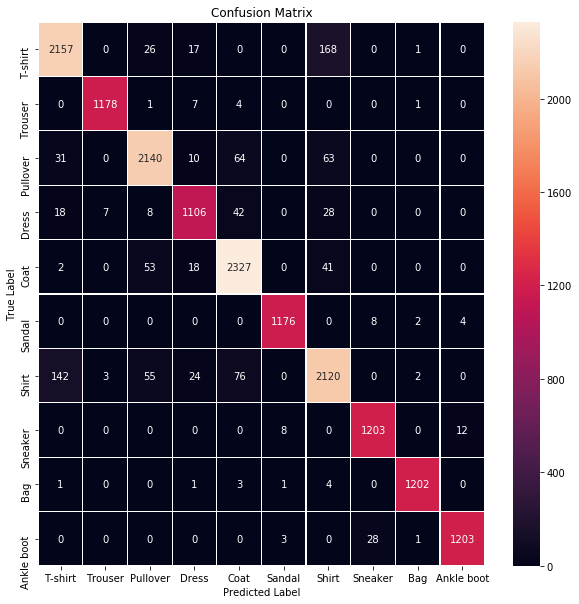

In [9]:
targets, predictions = validate(model, device, valid_loader)

tags = {
    0 :"T-shirt",
    1 :	"Trouser",
    2 :	"Pullover",
    3 : "Dress",
    4 :	"Coat",
    5 :	"Sandal",
    6 :	"Shirt",
    7 :	"Sneaker",
    8 :	"Bag",
    9 :	"Ankle boot"
}

labels = list(tags.values())
targets = [tags[num] for num in targets]
predictions = [tags[num] for num in predictions]
confusionMatrix = confusion_matrix(targets, predictions, labels)

f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, fmt='.0f', ax=ax, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# I found that T-shirt, shirt, Pullover and Coat are confusing so i add sample of these class as horizontal flip

In [20]:
training()
torch.save(model.state_dict(),"last_model.pt")

Train Epoch: 1 [0/84000 (0%)]	Loss: 0.063411
Train Epoch: 1 [10000/84000 (12%)]	Loss: 0.036694
Train Epoch: 1 [20000/84000 (24%)]	Loss: 0.054723
Train Epoch: 1 [30000/84000 (36%)]	Loss: 0.063214
Train Epoch: 1 [40000/84000 (48%)]	Loss: 0.038083
Train Epoch: 1 [50000/84000 (60%)]	Loss: 0.022281
Train Epoch: 1 [60000/84000 (71%)]	Loss: 0.011397
Train Epoch: 1 [70000/84000 (83%)]	Loss: 0.088393
Train Epoch: 1 [80000/84000 (95%)]	Loss: 0.025507
Train Epoch: 2 [0/84000 (0%)]	Loss: 0.017691
Train Epoch: 2 [10000/84000 (12%)]	Loss: 0.018109
Train Epoch: 2 [20000/84000 (24%)]	Loss: 0.034941
Train Epoch: 2 [30000/84000 (36%)]	Loss: 0.027225
Train Epoch: 2 [40000/84000 (48%)]	Loss: 0.031403
Train Epoch: 2 [50000/84000 (60%)]	Loss: 0.065170
Train Epoch: 2 [60000/84000 (71%)]	Loss: 0.026856
Train Epoch: 2 [70000/84000 (83%)]	Loss: 0.025339
Train Epoch: 2 [80000/84000 (95%)]	Loss: 0.063409
Train Epoch: 3 [0/84000 (0%)]	Loss: 0.024623
Train Epoch: 3 [10000/84000 (12%)]	Loss: 0.012344
Train Epoch: 3 

In [21]:
#Score of this model is 0.94400
make_prediction(model, device, test_loader,"last_result")

In [23]:
model = DeeperNet().to(device)
model.load_state_dict(torch.load("the_best_model.pt"))
model.eval()
#Score of this model is 0.94585
make_prediction(model, device, test_loader,"the_best_result")